# Time Series Analysis
## Data Gathering

In [105]:
import pandas as pd
import numpy as np
import os
import pandas as pd
from sklearn import preprocessing


cwd = os.getcwd()

In [2]:
data_url = [r"\Model Data\X Train.csv", r"\Model Data\X Test.csv", r"\Model Data\Y Train.csv", r"\Model Data\Y Test.csv"]

In [122]:
dataframes = [pd.read_csv(cwd + url) for url in data_url]
data_values = dataframes[:2]
data_labels = dataframes[2:]

data = pd.concat(data_values, ignore_index=True, axis=0)
labels = pd.concat(data_labels, ignore_index=True, axis=0)

joined_data = pd.concat([data, labels], axis=1)
joined_data = joined_data[joined_data.columns[~joined_data.columns.isin(["Counties_Idx"])]]

chrono_data = joined_data.sort_values(by=['Started_Date']).reset_index(drop=True).drop(columns="Started_Date")
chrono_data_values = chrono_data.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
chrono_data_scaled = min_max_scaler.fit_transform(chrono_data_values)
chrono_data = pd.DataFrame(chrono_data_scaled, columns=chrono_data.columns, index=chrono_data.index)
chrono_data.head()

,temperature,relative_humidity,wind_speed,wind_direction,total_precipitation,volumetric_soil_water_layer_1,Fire
0,0.231152,0.490683,0.387609,0.556686,0.0,0.519231,0.0
1,0.490391,0.428571,0.123908,0.451625,0.0,0.615385,0.0
2,0.496304,0.198758,0.184273,0.051669,0.0,0.134615,0.0
3,0.471173,0.459627,0.135822,0.404152,0.0,0.653846,0.0
4,0.523854,0.248447,0.157268,0.136302,0.0,0.153846,0.0


## Stationary Analysis

In [2]:
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from statsmodels.tsa.vector_ar.var_model import VAR

In [61]:
# null hypothesis that there isn't a statistically significant connection between out time series

jTestResult = coint_johansen(chrono_data.drop(["Started_Date"], axis=1), -1, 1)
print("Trace Stat:", jTestResult.trace_stat, end="\n\n")
print("Eig Stat: ", jTestResult.eig)

# Can reject the null hypothesis with 95% confidence for both trace and Eig Stat

Trace Stat: [12206.57315723 10150.27018816  8214.5754269   6322.2536129
  4465.57901224  2732.54874589  1103.61414314   198.69333494
    19.61521487]

Eig Stat:  [0.33734945 0.32116106 0.31524323 0.3103409  0.29306329 0.27818219
 0.16564209 0.03520258 0.0039177 ]


In [62]:
train_data = chrono_data.drop(["Started_Date"], axis=1)[:int(0.8 * len(chrono_data))]
valid_data = chrono_data.drop(["Started_Date"], axis=1)[int(0.8 * len(chrono_data)):]

## LSTM 

In [4]:
from matplotlib import pyplot
from math import sqrt
from sklearn.metrics import mean_squared_error

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from tensorflow.keras import optimizers

In [123]:
trainEnd = int(0.6 * len(chrono_data))
validEnd = trainEnd + int(0.2 * len(chrono_data))

train_data = chrono_data[:trainEnd]
valid_data = chrono_data[trainEnd:validEnd]
test_data = chrono_data[validEnd:]

train_X, train_Y = train_data[train_data.columns[~train_data.columns.isin(["Fire"])]], train_data[["Fire"]]
valid_X, valid_Y = valid_data[test_data.columns[~test_data.columns.isin(["Fire"])]], valid_data[["Fire"]]
test_X, test_Y = test_data[test_data.columns[~test_data.columns.isin(["Fire"])]], test_data[["Fire"]]

from collections import Counter

print(Counter(train_Y))
print(Counter(valid_Y))
print(Counter(test_Y))
train_X.head()

Counter({'Fire': 1})
Counter({'Fire': 1})
Counter({'Fire': 1})


,temperature,relative_humidity,wind_speed,wind_direction,total_precipitation,volumetric_soil_water_layer_1
0,0.231152,0.490683,0.387609,0.556686,0.0,0.519231
1,0.490391,0.428571,0.123908,0.451625,0.0,0.615385
2,0.496304,0.198758,0.184273,0.051669,0.0,0.134615
3,0.471173,0.459627,0.135822,0.404152,0.0,0.653846
4,0.523854,0.248447,0.157268,0.136302,0.0,0.153846


In [128]:
def prepareData(data, window_size):
    data_values = data.values
    result = []
    for i in range(window_size - 1, data.shape[0]):
        sample = []
        for j in range(window_size - 1, -1, -1):
            sample.append(data_values[i - j])
        result.append(sample)
        
    return np.array(result)


def prepareLabels(data, window_size):
    label_size = data.shape[0] - window_size + 1
    label_values = data.values[window_size - 1:]
    
    return label_values.reshape(label_size)

def lstm(train_X, train_Y, valid_X, valid_Y, test_X, test_Y, window_size=1, dropout=0.0):
    train_X_values = prepareData(train_X, window_size)
    valid_X_values = prepareData(valid_X, window_size)
    test_X_values = prepareData(test_X, window_size)
    
    train_Y_values = prepareLabels(train_Y, window_size)
    valid_Y_values = prepareLabels(valid_Y, window_size)
    test_Y_values = prepareLabels(test_Y, window_size)
    
    model = Sequential()
    model.add(LSTM(window_size, input_shape=(train_X_values.shape[1], train_X_values.shape[2]), dropout=dropout))
    model.add(Dense(50))
    model.add(Dense(25))
    model.add(Dense(10))
    model.add(Dense(5))
    model.add(Dense(1))
    
    opt = optimizers.Adam(learning_rate=0.01)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    
    history = model.fit(train_X_values, train_Y_values, epochs=10, batch_size=64, validation_data=(valid_X_values, valid_Y_values), verbose=2, shuffle=False)
    # plot history
    pyplot.plot(history.history['loss'], label='train')
    pyplot.plot(history.history['val_loss'], label='test')
    pyplot.legend()
    pyplot.show()
    
    print(model.evaluate(test_X_values, test_Y_values))
    

Epoch 1/10
46/46 - 4s - loss: 3.6696 - accuracy: 0.7614 - val_loss: 8.0038 - val_accuracy: 0.4811 - 4s/epoch - 90ms/step
Epoch 2/10
46/46 - 2s - loss: 3.6807 - accuracy: 0.7614 - val_loss: 8.0038 - val_accuracy: 0.4811 - 2s/epoch - 53ms/step
Epoch 3/10
46/46 - 2s - loss: 3.6807 - accuracy: 0.7614 - val_loss: 8.0038 - val_accuracy: 0.4811 - 2s/epoch - 53ms/step
Epoch 4/10
46/46 - 2s - loss: 3.6807 - accuracy: 0.7614 - val_loss: 8.0038 - val_accuracy: 0.4811 - 2s/epoch - 52ms/step
Epoch 5/10
46/46 - 2s - loss: 3.6807 - accuracy: 0.7614 - val_loss: 8.0038 - val_accuracy: 0.4811 - 2s/epoch - 52ms/step
Epoch 6/10
46/46 - 2s - loss: 3.6807 - accuracy: 0.7614 - val_loss: 8.0038 - val_accuracy: 0.4811 - 2s/epoch - 53ms/step
Epoch 7/10
46/46 - 2s - loss: 3.6807 - accuracy: 0.7614 - val_loss: 8.0038 - val_accuracy: 0.4811 - 2s/epoch - 53ms/step
Epoch 8/10
46/46 - 2s - loss: 3.6807 - accuracy: 0.7614 - val_loss: 8.0038 - val_accuracy: 0.4811 - 2s/epoch - 53ms/step
Epoch 9/10
46/46 - 2s - loss: 3.

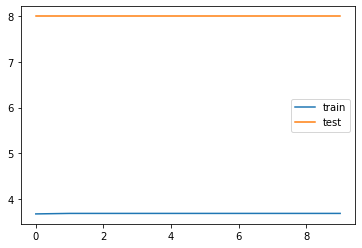

29/29 [==============================] - 0s 12ms/step - loss: 5.0960 - accuracy: 0.6696
[5.096047401428223, 0.669623076915741]


In [134]:
lstm(train_X, train_Y, valid_X, valid_Y, test_X, test_Y, window_size=100, dropout=0.6)

In [ ]:
model = Sequential()
model.add(LSTM(50, input_shape=(50, train_X.shape[2])))
model.add(Dense(1))
opt = optimizers.Adam(learning_rate=0.01)
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

In [ ]:
history = model.fit(train_X, train_Y, epochs=10, batch_size=64, validation_data=(valid_X, valid_Y), verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [62]:
model.evaluate(test_X, test_Y)

32/32 [==============================] - 0s 9ms/step - loss: 5.3317 - accuracy: 0.6543


[5.331700801849365, 0.6543456315994263]